In [26]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

path = 'data/'


In [27]:
bp = pd.read_csv('processed_data/bp_data.csv')
bp.shape

(514, 12)

In [28]:
ed = pd.read_csv('processed_data/ed_data.csv')
ed.shape

(514, 52)

In [29]:
geo = pd.read_csv('processed_data/geo_data.csv')
geo.shape

(514, 76)

In [30]:
lab = pd.read_csv('processed_data/lab_data.csv')
lab.shape

(514, 26)

In [31]:
visit = pd.read_csv('processed_data/visit_data.csv')
visit.shape

(514, 6)

In [32]:
mergecolumns = ['encrypt_mrn', 'ed_screened', 'visit_date', 'new_diagnosis', 'pcp_followup']

data = pd.merge(bp, ed, on=mergecolumns, how='left')
data = pd.merge(data, geo, on=mergecolumns, how='left')
data = pd.merge(data, lab, on=mergecolumns, how='left')
data = pd.merge(data, visit, on=mergecolumns, how='left')


In [33]:
data.shape

(514, 152)

In [34]:
data = data[data['new_diagnosis'] == 'Yes']
data.shape

(257, 152)

In [35]:
# follow up in data
data['pcp_followup'].value_counts()


pcp_followup
Yes    204
No      50
Name: count, dtype: int64

In [36]:
# follow up null 
data['pcp_followup'].isnull().sum()

3

In [37]:
# drop null
data = data.dropna(subset=['pcp_followup'])
data.shape

(254, 152)

In [38]:
data.to_csv('processed_data/merged_data.csv', index=False)

In [39]:
list_bp = ['avg_dbp', 'avg_diff', 'avg_sbp', 'max_sbp']

In [40]:
list_ed = ['age', 'sex', 'language', 'insurance_type', 'primary_care', 
            'ed_name', 'bpa_response', 'htn_on_pl', 'htn_on_pmh', 
            'hld_on_pl', 'hld_on_pmh', 'family_dm', 'tobacco_user', 
            'htn_meds', 'statin_meds', 'disposition', 'detailed_race', 
            'weight', 'bmi', 'hba1c', 'height', 'sbp_1st', 'dbp_1st', 
            'poct_gluc']

In [41]:
list_lab = ['max_value_GLUCOSE', 'avg_value_GLUCOSE', 'max_value_CREATININE', 'min_value_CREATININE', 'min_value_GLUCOSE',  'avg_value_CREATININE', 'avg_value_HEMOGLOBIN A1C', 'max_value_HEMOGLOBIN A1C', 'min_value_HEMOGLOBIN A1C',  'min_value_GLUCOSE, POC', 'avg_value_GLUCOSE, POC', 'max_value_GLUCOSE, POC']

In [42]:
list_geo = [
    'po_box', 'homeless', 'total_pop', 'households', 'housing_units', 
    'p_children', 'p_elderly', 'p_adults', 'p_female', 'mdn_age', 
    'p_nhwhite', 'p_nhblack', 'p_hispanic', 'p_nhasian', 'p_other', 
    'p_moved', 'p_longcommute', 'p_marriednone', 'p_marriedkids', 
    'p_singlenone', 'p_malekids', 'p_femalekids', 'p_cohabitkids', 
    'p_nohsdeg', 'p_hsonly', 'p_somecollege', 'p_collegeplus', 
    'p_onlyenglish', 'p_spanishlimited', 'p_asianlimited', 'p_otherlimited', 
    'p_limitedall', 'p_notlimited', 'p_popbelow1fpl', 'p_popbelow2fpl', 
    'p_povmarriedfam', 'p_povmalefam', 'p_povfemalefam', 'hh_mdnincome', 
    'p_pubassist', 'p_foodstamps', 'p_assistorfood', 'p_unemployed', 
    'h_vacant', 'h_renter', 'h_occupants', 'h_novehicles', 'h_mdnrent', 
    'h_rentpercent', 'h_houseprice', 'p_private', 'p_medicare', 'p_medicaid', 
    'p_otherinsur', 'p_uninsured', 'h_nointernet', 'h_nocomputer', 
    'p_foreign', 'p_disabled'
]

In [43]:
list_visit = ['visit_type']

In [44]:
lists = list_bp+ list_ed+ list_lab+ list_geo+ list_visit
X_all = data[lists]
y = data['pcp_followup'].map({'Yes': 1, 'No': 0})
y = np.array(y).astype(int)

In [45]:
# Identify numeric and categorical columns
numeric_cols = X_all.select_dtypes(include=['number']).columns
categorical_cols = X_all.select_dtypes(exclude=['number']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

X_preprocessed = preprocessor.fit_transform(X_all)

    # Convert sparse matrix to dense
if hasattr(X_preprocessed, "toarray"):
    X_preprocessed = X_preprocessed.toarray()

X_train_val, X_test, y_train_val, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=50)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=50)


In [46]:
lasso = Lasso(alpha=0.00001, max_iter=100000, tol=1e-10, random_state=50, selection='random', precompute=True)
lasso.fit(X_train, y_train)

Lasso(alpha=1e-05, max_iter=100000, precompute=True, random_state=50,
      selection='random', tol=1e-10)

In [47]:
numeric_feature_names = numeric_cols 
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)

all_feature_names = list(numeric_feature_names) + list(cat_feature_names)

coef = lasso.coef_

feature_importance = pd.DataFrame({
    'feature': all_feature_names,
    'importance': coef
})

feature_importance = feature_importance.sort_values('importance', ascending=False)
print(feature_importance.head(10))

print(feature_importance.tail(10))


                      feature  importance
24   min_value_HEMOGLOBIN A1C    2.902262
18       max_value_CREATININE    1.140566
19       min_value_CREATININE    0.975624
90       insurance_type_OTHER    0.571713
99             htn_on_pmh_Yes    0.256885
100             hld_on_pl_Yes    0.230091
20          min_value_GLUCOSE    0.198079
15                  poct_gluc    0.186203
96      ed_name_NYU MANHATTAN    0.185250
94    ed_name_NYU COBBLE HILL    0.180070
                           feature  importance
16               max_value_GLUCOSE   -0.278219
109            detailed_race_Black   -0.307580
113            detailed_race_Other   -0.310384
26          avg_value_GLUCOSE, POC   -0.377700
112           detailed_race_Native   -0.388539
87                  language_Other   -0.564004
111         detailed_race_Multiple   -0.651062
114  detailed_race_Unknown/Refused   -1.367319
21            avg_value_CREATININE   -2.064041
23        max_value_HEMOGLOBIN A1C   -2.899669


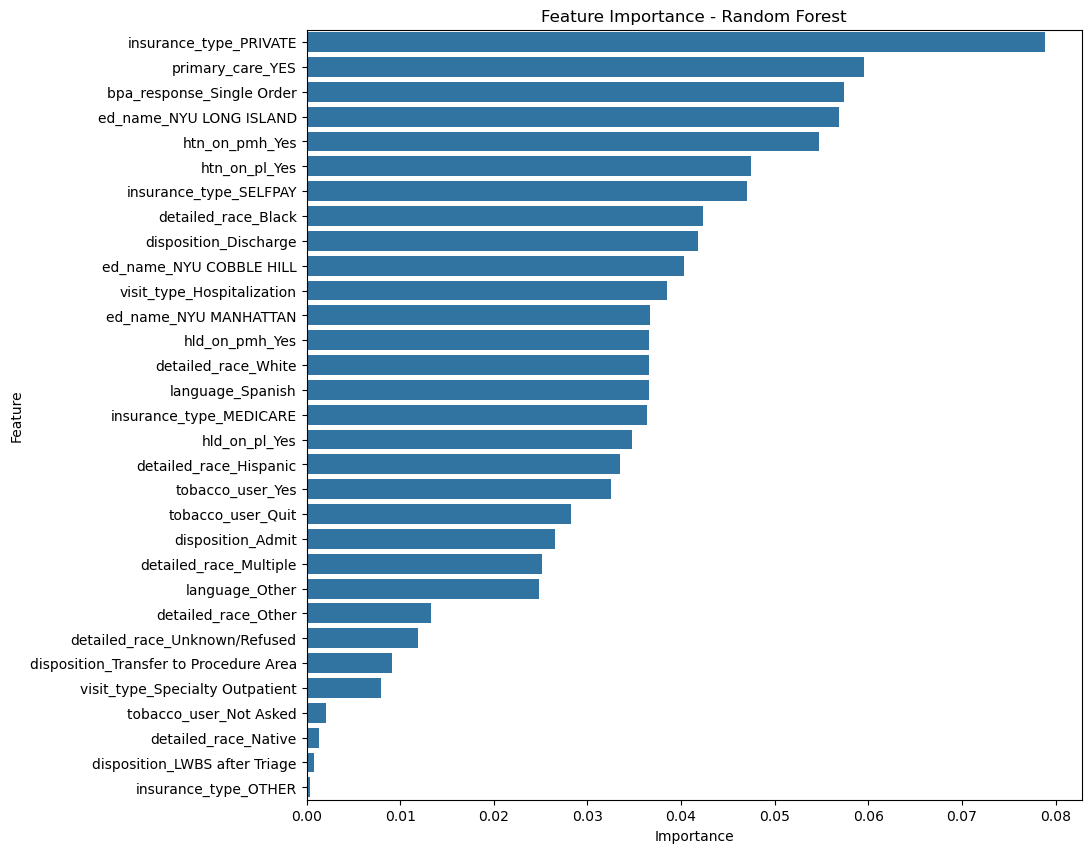

In [48]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

X = data[lists]
y = data['pcp_followup']
categorical_columns = X.select_dtypes(include=['object']).columns
X_categorical = X[categorical_columns]
X_encoded = pd.get_dummies(X_categorical, drop_first=True)

rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(X_encoded, y)

importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_features = feature_importance_df

plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Feature Importance - Random Forest')
plt.show()

                 Feature  Importance
30             total_pop    0.024510
82           p_uninsured    0.024417
78             p_private    0.019548
44         p_longcommute    0.019366
21  avg_value_CREATININE    0.019362
..                   ...         ...
64          p_povmalefam    0.003624
6              family_dm    0.002372
5                    sex    0.000324
29              homeless    0.000000
28                po_box    0.000000

[87 rows x 2 columns]


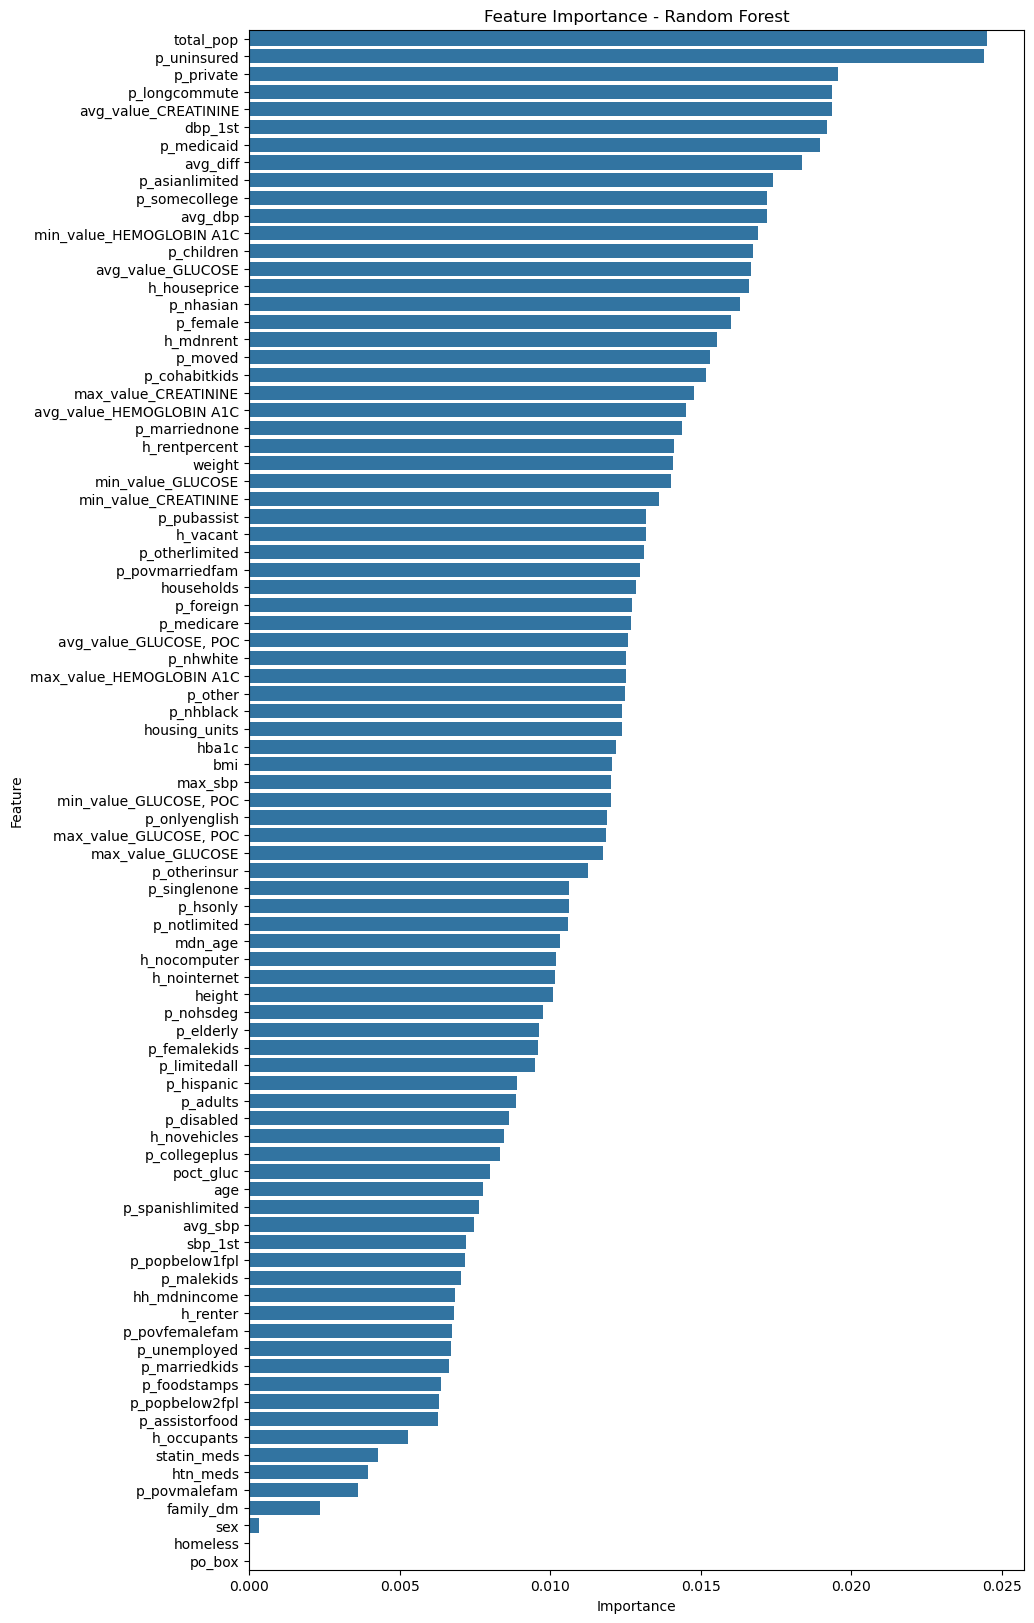

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

X = data[lists].select_dtypes(include=['number'])
y = data['pcp_followup']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(X_scaled, y)

importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(10, 20))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance - Random Forest')
plt.show()
